### PyTorch Torchvision: COCO 8 Instance Segmentation

In [1]:
# import libraries
import io
import gc
import cv2
import mlflow
import torch
import torchvision
import numpy as np
from torchvision import tv_tensors
from torchvision.transforms import v2
from torchvision.transforms.v2 import functional as F
from pycocotools.coco import COCO
from typing import Any, Tuple
from torchvision import datasets
from torchvision.ops.boxes import box_convert
from torch.utils.data import DataLoader
from contextlib import redirect_stdout
from torchvision.models.detection.mask_rcnn import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image, ImageDraw
from torchvision.datasets import coco
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from numpy import uint8
import torch.nn.functional as F2
from torchvision.ops.boxes import nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

print(torchvision.__version__)

0.16.2+cu118


In [2]:
# basic function usage
def collate_fn(batch):
    return tuple(zip(*batch))

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fig, axs = plt.subplots(ncols = len(imgs), squeeze = False)
    
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels = [], yticklabels = [], xticks = [], yticks = []) 

In [3]:
# custom dataset class
class InstanceSegmentation(datasets.CocoDetection):
    def __init__(self, root, annFile, transform):
        super(InstanceSegmentation, self).__init__(root, annFile, transform)
        self.coco = COCO(annFile)
        self.dataset = self.coco.dataset
        self.v2_transform = transform
        self.annFile = annFile

    def __getitem__(self, index) -> Tuple[Any, Any]:
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        # image, target = super(InstanceSegmentation, self).__getitem__(index)

        if self.v2_transform is not None:
            height, width = image.height, image.width
            original_bounding_box = torch.tensor([t['bbox'] for t in target])
            bounding_box_xyxy = box_convert(original_bounding_box, in_fmt = 'xywh', out_fmt = 'xyxy')
            tv_tensor_bounding_box_xyxy = tv_tensors.BoundingBoxes(bounding_box_xyxy, format = "XYXY", canvas_size = (height, width))
            label = torch.tensor([t['category_id'] for t in target])
            mask_np = np.array([self.coco.annToMask(t) for t in target])
            mask = torch.tensor(mask_np)
            # refer below link for more information
            # https://pytorch.org/blog/extending-torchvisions-transforms-to-object-detection-segmentation-and-video-tasks/#the-new-transforms-api
            transform_image, transform_bounding_box, transform_mask, transform_label = self.v2_transform(image, tv_tensor_bounding_box_xyxy, mask, label)
            # transform_mask = F.resize_mask(mask, size = [250, 250])

        dic = {
            "boxes": [],
            "labels": [],
            "image_id": -1,
            "masks": []
        }

        if not all(x == target[0]["image_id"] for x in [t["image_id"] for t in target]):
            raise ValueError("Not all values are equal in the list.")
        else:
            dic["image_id"] = target[0]["image_id"] 

        dic["boxes"] = transform_bounding_box
        dic["labels"] = transform_label
        dic["masks"] = transform_mask

        return transform_image, dic

    def __len__(self) -> int:
        return len(self.ids)

    def getImgIds(self, imgIds = [], catIds = []):
        return self.coco.getImgIds(imgIds = [], catIds = [])

    def getCatIds(self, catNms = [], supNms = [], catIds = []):
        return self.coco.getCatIds(catNms = [], supNms = [], catIds = [])

    def loadAnns(self, ids = []):
        return self.coco.loadAnns(ids = ids)

    def getAnnIds(self, imgIds = [], catIds = [], areaRng = [], iscrowd = None):
        return self.coco.getAnnIds(imgIds = imgIds, catIds = catIds, areaRng = areaRng, iscrowd = iscrowd)

#### 1. Setup MLflow experiment tracking

In [4]:
# delete experiment name
# mlflow.delete_experiment(experiment_id = '1')

In [5]:
# setup mlflow experiment
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("coco8-instance-seg")

2024/05/07 11:48:03 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/07 11:48:03 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='file:///d:/Git/computer-vision-deep-learning-project/project/instance_segmentation/coco8_seg/mlruns/1', creation_time=1715053683958, experiment_id='1', last_update_time=1715053683958, lifecycle_stage='active', name='coco8-instance-seg', tags={}>

#### 2. Data Preparation

In [6]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    # v2.Resize((250, 250)),
    v2.ToDtype(torch.float32, scale = True),
])

with redirect_stdout(io.StringIO()):
    training_dataset = InstanceSegmentation(
        # root = "dataset/first_pcb_sample/train/images", 
        # annFile = "dataset/first_pcb_sample/train/annotations/train.json",
        root = "../../../dataset/coco8-seg/train/images", 
        annFile = "../../../dataset/coco8-seg/train/annotation/_annotations.coco.json",
        transform = transform
    )
    validation_dataset = InstanceSegmentation(
        # root = "dataset/first_pcb_sample/val/images", 
        # annFile = "dataset/first_pcb_sample/val/annotations/val.json",
        root = "../../../dataset/coco8-seg/valid/images", 
        annFile = "../../../dataset/coco8-seg/valid/annotation/_annotations.coco.json",
        transform = transform
    )

training_dataloader = DataLoader(
    training_dataset, 
    batch_size = 1,
    shuffle = True,
    num_workers = 0,
    collate_fn = collate_fn
)

with redirect_stdout(io.StringIO()):
    coco_training = COCO("../../../dataset/coco8-seg/train/annotation/_annotations.coco.json")
    coco_validation = COCO("../../../dataset/coco8-seg/valid/annotation/_annotations.coco.json")

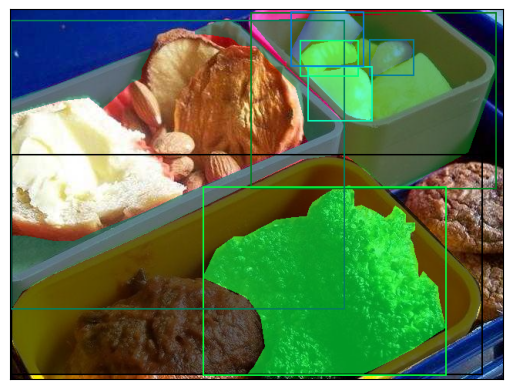

In [7]:
# visualization
train_features_batch, train_labels_batch = next(iter(training_dataloader))

image = train_features_batch[0].numpy().transpose((1, 2, 0))
ground_truth = train_labels_batch[0]['boxes']
masks = train_labels_batch[0]['masks']

# fig, ax = plt.subplots(1)
# ax.imshow(image)

# print(masks.shape)
# print(ground_truth.shape)

# for box in ground_truth:
#     rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
#         linewidth = 1, edgecolor = 'r', facecolor = 'none')
#     ax.add_patch(rect)

# plt.axis('off')
# plt.show()

image_uint8 = (train_features_batch[0] * 255).byte()
masks_bool = masks.bool()
result = draw_segmentation_masks(image_uint8, masks = masks_bool, alpha = 0.6)
result_with_boxes = draw_bounding_boxes(result, ground_truth, width = 2)

show(result_with_boxes)

#### 3. Model Construction

In [8]:
class_number_plus_background = len(training_dataset.coco.cats) + 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = maskrcnn_resnet50_fpn_v2(weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT)

# in_features = model.roi_heads.box_predictor.cls_score.in_features
# model.roi_heads.box_predictor = FastRCNNPredictor(in_features, class_number_plus_background)

# in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
# dim_reduced = model.roi_heads.mask_predictor.conv5_mask.out_channels
# model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, dim_reduced, class_number_plus_background)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

# unfrozen, set all parameters to require gradients to true
for param in model.parameters():
    param.requires_grad = True

print(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

#### 4. Model Training

In [9]:
def print_auto_logged_info(r):
    tags = {k: v for k, v in r.data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in mlflow.MlflowClient().list_artifacts(r.info.run_id, "model")]

    print(f"run_id: {r.info.run_id}")
    print(f"artifacts: {artifacts}")
    print(f"params: {r.data.params}")
    print(f"metrics: {r.data.metrics}")
    print(f"tags: {tags}")

In [11]:
selected_keys = ['boxes', 'labels', 'masks']

# auto log all entities
mlflow.pytorch.autolog(disable = False, log_every_n_epoch = 1)

with mlflow.start_run() as run:
    # log detail
    mlflow.set_tag("developer", "christopher")

    # log parameters
    mlflow.log_param("train-data-path", training_dataset.root)
    mlflow.log_param("valid-data-path", validation_dataset.root)
    mlflow.log_param("train-annotation-path", training_dataset.annFile)
    mlflow.log_param("valid-annotation-path", validation_dataset.annFile)

    for epoch in range(5):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, targets) in enumerate(training_dataloader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items() if k in selected_keys} for t in targets]

            # forward pass
            loss_dict = model(images, targets)
            loss = sum(loss for loss in loss_dict.values())

            # backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # delete tensor and clear cache to free up memory
            del images, targets, loss_dict
            # clear system memory
            gc.collect()

        # clear cache after each epoch
        torch.cuda.empty_cache()
        # clear system memory
        gc.collect()

        # print total train loss per epoch
        total_train_loss = train_loss / len(training_dataloader)

        # log training loss
        mlflow.log_metric("total_train_loss", total_train_loss, step = (epoch + 1))

        print(f'Epoch {epoch + 1}, Loss: {total_train_loss}')
        print(f'Max allocated memory: {torch.cuda.max_memory_allocated(device) / 1024 ** 2} MB, Allocated memory: {torch.cuda.memory_allocated(device) / 1024 ** 2} MB')
        print(f'Max reserved memory: {torch.cuda.max_memory_reserved(device) / 1024 ** 2} MB, Reserved memory: {torch.cuda.memory_reserved(device) / 1024 ** 2} MB')
        print("")

    # log/ save the model to artifact
    mlflow.pytorch.log_model(model, "model")
    mlflow.pytorch.save_model(model, "scripted_model")

    # convert to scripted model and log/ save the model
    scripted_model = torch.jit.script(model)
    mlflow.pytorch.log_model(scripted_model, "scripted_model")
    mlflow.pytorch.save_model(scripted_model, "scripted_model")

# get the auto logged parameters and metrics
print_auto_logged_info(mlflow.get_run(run_id = run.info.run_id))

env = mlflow.pytorch.get_default_conda_env()
print(f"conda env: {env}")

Epoch 1, Loss: 0.31506239995360374
Max allocated memory: 3101.26220703125 MB, Allocated memory: 563.513671875 MB
Max reserved memory: 3680.0 MB, Reserved memory: 2044.0 MB

Epoch 2, Loss: 0.3088371157646179
Max allocated memory: 3101.26220703125 MB, Allocated memory: 561.529296875 MB
Max reserved memory: 3680.0 MB, Reserved memory: 2042.0 MB

Epoch 3, Loss: 0.2632650136947632
Max allocated memory: 3101.26220703125 MB, Allocated memory: 562.55078125 MB
Max reserved memory: 3680.0 MB, Reserved memory: 1934.0 MB

Epoch 4, Loss: 0.262173168361187
Max allocated memory: 3101.26220703125 MB, Allocated memory: 564.646484375 MB
Max reserved memory: 3680.0 MB, Reserved memory: 2002.0 MB

Epoch 5, Loss: 0.2264585830271244
Max allocated memory: 3101.26220703125 MB, Allocated memory: 563.869140625 MB
Max reserved memory: 4048.0 MB, Reserved memory: 2092.0 MB



2024/05/07 11:49:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.1.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/07 11:49:28 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.16.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.16.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/05/07 11:49:28 WARNING mlflow.utils.requirements_utils: Found torchaudio version (2.1.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchaudio==2.1.2' without the local ver

MlflowException: Path 'd:\Git\computer-vision-deep-learning-project\project\instance_segmentation\coco8_seg\scripted_model' already exists and is not empty

#### 5. Inference

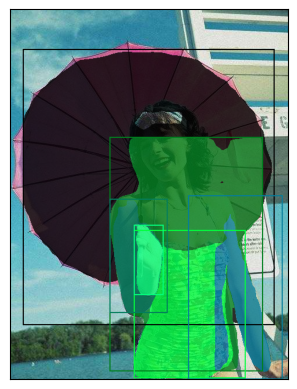

In [10]:
cpu_device = torch.device("cpu")

resize_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.Resize((640, 640), antialias = True),
    v2.ToDtype(torch.float32, scale = True),
])

image_path = "../../../dataset/coco8-seg/valid/images/000000000036_jpg.rf.6783d468f8475090f3d3f214930df8aa.jpg"

ori_img = Image.open(image_path)
ori_img = transform(ori_img).unsqueeze(0).to(cpu_device)

image = Image.open(image_path)
image = resize_transform(image).unsqueeze(0).to(cpu_device)

model.to(cpu_device)
model.eval()

with torch.no_grad():
# with torch.inference_mode():
    output = model(image)
    masks = output[0]['masks'].squeeze(1)
    
    # total_mask = masks.sum(axis = 0)
    # total_mask = total_mask / total_mask.max()

    ori_height, ori_width = ori_img.squeeze(0).shape[1], ori_img.squeeze(0).shape[2]
    cur_height, cur_width = image.squeeze(0).shape[1], image.squeeze(0).shape[2]

    resized_masks = torch.empty((len(masks), ori_height, ori_width))

    for i, mask in enumerate(masks):
        masks_pil = Image.fromarray(mask.numpy())
        masks_resized = F.resize(masks_pil, [ori_height, ori_width])
        masks_resized_tensor = torch.from_numpy(np.array(masks_resized))
        resized_masks[i] = masks_resized_tensor

    masks_tensor_bool = resized_masks > 0.5

    boxes = output[0]['boxes']
    width_scale = ori_width / cur_width
    height_scale = ori_height / cur_height

    scaled_boxes = []

    for box in boxes:
        scaled_box = [
            box[0] * width_scale, 
            box[1] * height_scale, 
            box[2] * width_scale, 
            box[3] * height_scale
        ]
        scaled_boxes.append(scaled_box)

    scaled_boxes_tensor = torch.tensor(scaled_boxes)

    scores = output[0]['scores']

    keep = nms(boxes, scores, iou_threshold = 0.5)
    scaled_boxes_tensor = scaled_boxes_tensor[keep]
    masks_tensor_bool = masks_tensor_bool[keep]

    image_uint8 = (ori_img.squeeze(0) * 255).to(torch.uint8)
    result = draw_segmentation_masks(image_uint8, masks = masks_tensor_bool, alpha = 0.8)
    # colors = ['red'] * len(scaled_boxes_tensor)
    # result_with_boxes = draw_bounding_boxes(result, scaled_boxes_tensor, width = 5, colors = colors)
    result_with_boxes = draw_bounding_boxes(result, scaled_boxes_tensor, width = 2)

    show(result_with_boxes)